In [1927]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1928]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pingouin import multivariate_normality
import scipy.stats as stats
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, fbeta_score


from package.data_prep import check_df_info,check_duplicates,filter_and_convert_columns,clean_dataframe,convert_fraud_column,merge_model_results
from package.mahalanobis import check_multivariate,check_all_columns_normality,check_normality_anderson,normalize_column,check_determinant,robust_mahalanobis_anomaly,add_pvalue_to_result,evaluate_percentile_alpha_performance_with_best
from package.dbscan import plot_tsne_clusters,dbscan_anomaly,evaluate_dbscan_performance_with_best
from package.isolation_forest import isolation_forest,evaluate_if_performance_with_best
from package.edamodel import plot_pca_anomaly
from package.evaluate import evaluate_binary_classification
from package.ensemble import weighted_voting_from_scores,stacking_xgb



In [1929]:
df = pd.read_excel("Worksheet in Case Study question 2.xlsx")

df.head()


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [1930]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   months_as_customer           1000 non-null   int64         
 1   age                          1000 non-null   int64         
 2   policy_number                1000 non-null   int64         
 3   policy_bind_date             1000 non-null   datetime64[ns]
 4   policy_state                 1000 non-null   object        
 5   policy_csl                   1000 non-null   object        
 6   policy_deductable            1000 non-null   int64         
 7   policy_annual_premium        1000 non-null   float64       
 8   umbrella_limit               1000 non-null   int64         
 9   insured_zip                  1000 non-null   int64         
 10  insured_sex                  1000 non-null   object        
 11  insured_education_level      1000 non-null  

In [1931]:
df


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,...,1,?,87200,17440,8720,61040,Honda,Accord,2006,N
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,...,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,...,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,...,1,YES,46980,5220,5220,36540,Audi,A5,1998,N


# EDA

In [1932]:
df.columns


Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported'],
      dtype='object')

In [1933]:
df['policy_number'].duplicated().sum()  # ดูว่ามีค่าซ้ำไหม


0

In [1934]:
df[df["fraud_reported"] == "N"]["total_claim_amount"].mean()


50288.605577689246

In [1935]:
df[df["fraud_reported"] == "Y"]["total_claim_amount"].mean()


60302.10526315789

In [1936]:
fig = px.histogram(df, x="total_claim_amount", color='fraud_reported')
fig.show()


In [1937]:
fig = px.histogram(df, x="incident_hour_of_the_day", color='fraud_reported')
fig.show()


In [1938]:
df.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported'],
      dtype='object')

In [1939]:
fig = px.histogram(df, x="injury_claim", color='fraud_reported',title='จำนวน Fraud และ Non-Fraud แยกตามจำนวนเงินที่เรียกร้องค่าเสียหาย',
                  labels={'injury_claim': 'จำนวนเงินที่เรียกร้องค่าเสียหาย', 'count': 'จำนวน',
                     'fraud_status': 'สถานะ'})
fig.show()

In [1940]:
fig = px.histogram(df, x="property_claim", color='fraud_reported',title='จำนวน Fraud และ Non-Fraud แยกตามจำนวนเงินที่เรียกร้องค่าเสียหายทรัพย์สิน',
                  labels={'property_claim': 'จำนวนเงินที่เรียกร้องค่าเสียหายทรัพย์สิน', 'count': 'จำนวน',
                     'fraud_status': 'สถานะ'})
fig.show()

In [1941]:
fig = px.histogram(df, x="vehicle_claim", color='fraud_reported',title='จำนวน Fraud และ Non-Fraud แยกตามจำนวนเงินที่เรียกร้องค่าเสียหายยานพาหนะ',
                  labels={'vehicle_claim': 'จำนวนเงินที่เรียกร้องค่าเสียหายยานพาหนะ', 'count': 'จำนวน',
                     'fraud_status': 'สถานะ'})
fig.show()


In [1942]:
fig = px.histogram(df, x="months_as_customer", color='fraud_reported')
fig.show()


In [1943]:
fig = px.histogram(df, x="policy_annual_premium", color='fraud_reported',
                  title='จำนวน Fraud และ Non-Fraud แยกตามจำนวนเงินที่จ่าย',
                  labels={'policy_annual_premium': 'จำนวนเงินที่ลูกค้าจ่าย', 'count': 'จำนวน',
                     'fraud_status': 'สถานะ'})
fig.show()


In [1944]:
fig = px.histogram(df, x="bodily_injuries", color='fraud_reported')
fig.show()


In [1945]:
df_analysis = df.copy()
# สร้างกลุ่มอายุ
# สร้างกลุ่มอายุ
bins = [0, 19, 29, 39, 49, 59, 69, 79, 100]
labels = ['<20', '20–29', '30–39', '40–49', '50–59', '60–69', '70–79', '80+']
df_analysis['age_group'] = pd.cut(
    df_analysis['age'], bins=bins, labels=labels, right=True)

# สร้างตารางสรุป fraud กับ non-fraud ในแต่ละกลุ่มอายุ
summary = df_analysis.groupby(
    ['age_group', 'fraud_reported']).size().reset_index(name='count')

# แปลงค่าความหมายของ is_fraud เป็นข้อความ
summary['fraud_status'] = summary['fraud_reported'].map(
    {"N": 'Non-Fraud', "Y": 'Fraud'})
summary['total'] = summary.groupby('age_group')['count'].transform('sum')
summary['percent'] = (summary['count'] / summary['total'] * 100).round(2)

# สร้างกราฟ stacked bar
fig = px.bar(summary, x='age_group', y='count', color='fraud_status',
             title='จำนวน Fraud และ Non-Fraud แยกตามช่วงอายุ',
             labels={'age_group': 'ช่วงอายุ', 'count': 'จำนวน',
                     'fraud_status': 'สถานะ', 'percent': "เปอร์เซ็นต์"},
             barmode='stack',
             hover_data={'percent': True, 'count': True,
                         'fraud_status': True, 'age_group': True}
             )
fig.show()


/var/folders/qc/wbl1sccd3yn5ndpj0nb5bp7w0000gn/T/ipykernel_4849/674156307.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/qc/wbl1sccd3yn5ndpj0nb5bp7w0000gn/T/ipykernel_4849/674156307.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [1946]:
import pandas as pd
import plotly.express as px

df_analysis = df.copy()

# 🔹 กำหนดช่วง (bins) และ labels สำหรับ months_as_customer
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, float('inf')]
labels = [
    '0–49', '50–99', '100–149', '150–199', '200–249', '250–299',
    '300–349', '350–399', '400–449', '450–499', '500+'
]

# 🔹 สร้างกลุ่มตามช่วง months_as_customer
df_analysis['months_group'] = pd.cut(
    df_analysis['months_as_customer'], bins=bins, labels=labels, right=False)

# 🔹 สร้างตารางสรุป
summary = df_analysis.groupby(['months_group', 'fraud_reported']).size().reset_index(name='count')
summary['fraud_status'] = summary['fraud_reported'].map({"Y": 'Fraud', "N": 'Non-Fraud'})
summary['total'] = summary.groupby('months_group')['count'].transform('sum')
summary['percent'] = (summary['count'] / summary['total'] * 100).round(2)

# 🔹 สร้าง stacked bar chart
fig = px.bar(
    summary,
    x='months_group', y='count', color='fraud_status',
    title='จำนวน Fraud และ Non-Fraud แยกตามช่วงเวลาที่เป็นลูกค้า (Months)',
    labels={
        'months_group': 'ช่วง Months as Customer',
        'count': 'จำนวน',
        'fraud_status': 'สถานะ Fraud',
        'percent': "เปอร์เซ็นต์"
    },
    barmode='stack',
    hover_data={'percent': True, 'count': True, 'fraud_status': True, 'months_group': True}
)

fig.show()

/var/folders/qc/wbl1sccd3yn5ndpj0nb5bp7w0000gn/T/ipykernel_4849/1548078218.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/qc/wbl1sccd3yn5ndpj0nb5bp7w0000gn/T/ipykernel_4849/1548078218.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [1947]:
df_N = df[df["fraud_reported"] == "N"]


In [1948]:
df_Y = df[df["fraud_reported"] == "Y"]
df_Y


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
5,256,39,104594,2006-10-12,OH,250/500,1000,1351.10,0,478456,...,2,NO,64100,6410,6410,51280,Saab,95,2003,Y
14,180,38,644081,1998-12-28,OH,250/500,2000,1301.13,0,476685,...,2,YES,46200,4200,8400,33600,Dodge,Neon,2003,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,234,41,291006,1990-05-16,IN,100/300,500,951.56,0,455426,...,1,?,98280,15120,7560,75600,Chevrolet,Tahoe,2007,Y
977,266,42,929306,2003-03-06,IN,100/300,500,1093.83,4000000,468454,...,1,NO,53280,4440,8880,39960,Suburu,Impreza,2015,Y
982,230,43,490514,2007-02-09,IN,500/1000,2000,1101.83,0,451529,...,3,YES,51900,5190,10380,36330,BMW,M5,2011,Y
986,232,42,182953,2013-04-30,IN,100/300,500,944.03,0,440153,...,3,?,77000,15400,7700,53900,Toyota,Highlander,2015,Y


In [1949]:
# คำนวณจำนวน fraud และ total ต่อ state
fraud_summary = df.groupby('incident_state')[
    'fraud_reported'].value_counts().unstack().fillna(0)
fraud_summary['total'] = fraud_summary.sum(axis=1)
fraud_summary['fraud_percent'] = (
    fraud_summary['Y'] / fraud_summary['total'] * 100).round(2)
fraud_summary['total_fraud'] = fraud_summary['Y']

# สร้าง DataFrame สรุป
state_fraud_percent = fraud_summary.reset_index(
)[['incident_state', 'fraud_percent', 'total', 'total_fraud']]
state_fraud_percent


fraud_reported,incident_state,fraud_percent,total,total_fraud
0,NC,30.91,110,34
1,NY,22.14,262,58
2,OH,43.48,23,10
3,PA,26.67,30,8
4,SC,29.44,248,73
5,VA,22.73,110,25
6,WV,17.97,217,39


In [1950]:
fig = px.choropleth(state_fraud_percent,
                    locations='incident_state',         # รหัสรัฐ เช่น 'NY', 'PA'
                    locationmode='USA-states',
                    color='fraud_percent',              # ใช้ % แทน count
                    color_continuous_scale='Reds',
                    scope='usa',
                    labels={'fraud_percent': '% Fraud'},
                    title='Fraud % by Incident State',
                    hover_data={'incident_state': True, 'fraud_percent': True, 'total': True, 'total_fraud': True})
fig.show()


In [1951]:
# เลือกเฉพาะคอลัมน์ที่เป็น int
df_int = df.select_dtypes(include='int')

# คำนวณ correlation
corr_matrix = df_int.corr()

# แสดงผล


fig = px.imshow(corr_matrix,
                text_auto=True,
                title="Correlation Matrix of Integer Columns",
                color_continuous_scale='RdBu_r',
                zmin=-1, zmax=1)
fig.show()


# EDA func isnull

In [1952]:
df = pd.read_excel("Worksheet in Case Study question 2.xlsx", dtype=str)

df.head()


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17 00:00:00,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27 00:00:00,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06 00:00:00,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25 00:00:00,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06 00:00:00,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


func ckeck info

In [1953]:
summary = check_df_info(df)
summary


,column,dtype,null_count,null_percent,total_rows,outlier_count
0,months_as_customer,object,0,0.0,1000,None
1,age,object,0,0.0,1000,None
2,policy_number,object,0,0.0,1000,None
3,policy_bind_date,object,0,0.0,1000,None
4,policy_state,object,0,0.0,1000,None
5,policy_csl,object,0,0.0,1000,None
6,policy_deductable,object,0,0.0,1000,None
7,policy_annual_premium,object,0,0.0,1000,None
8,umbrella_limit,object,0,0.0,1000,None
9,insured_zip,object,0,0.0,1000,None


check duplicates

In [1954]:
dup_info = check_duplicates(df)
print("จำนวนแถวซ้ำ:", dup_info['total_duplicates'])
print("ตรวจจากคอลัมน์:", dup_info['columns_checked'])


จำนวนแถวซ้ำ: 0
ตรวจจากคอลัมน์: all columns


select and convert to int 

In [1955]:
df_select_int = filter_and_convert_columns(df)
summary = check_df_info(df_select_int)
summary


,column,dtype,null_count,null_percent,total_rows,outlier_count
0,months_as_customer,int64,0,0.0,1000,0
1,injury_claim,int64,0,0.0,1000,0
2,property_claim,int64,0,0.0,1000,6
3,vehicle_claim,int64,0,0.0,1000,0
4,policy_annual_premium,float64,0,0.0,1000,9


mockup data to drop nan ,dup ,outliers

In [1956]:
# โหลดชื่อคอลัมน์จากไฟล์
columns = pd.read_csv('int_to_mockup.csv', dtype=str).columns.tolist()

# สร้าง mockup ข้อมูลพื้นฐาน
np.random.seed(42)
n = 100  # จำนวน row
df_mockup = pd.DataFrame(
    {col: np.random.randint(10, 1000, n) for col in columns})

#  1. แทรก NaN 5% ในแต่ละคอลัมน์
for col in df_mockup.columns:
    nan_indices = np.random.choice(
        df_mockup.index, size=int(0.05 * n), replace=False)
    df_mockup.loc[nan_indices, col] = np.nan

#  2. เพิ่ม duplicated row (เช่น 3 rows)
df_mockup = pd.concat([df_mockup, df_mockup.iloc[:3]], ignore_index=True)

#  3. แทรก outlier: คูณบางค่าด้วย 10 ในบางคอลัมน์
for col in df_mockup.columns[:3]:  # ทำแค่บางคอลัมน์แรก
    outlier_indices = np.random.choice(df_mockup.index, size=2, replace=False)
    df_mockup.loc[outlier_indices, col] = df_mockup[col].max() * 10

df_mockup.reset_index(drop=True, inplace=True)
df_mockup


,months_as_customer,age,policy_deductable,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,injury_claim,property_claim,vehicle_claim,auto_year,policy_annual_premium
0,112.0,565.0,743.0,256.0,NaN,635.0,NaN,586.0,900.0,943.0,186.0,490.0,NaN,146.0,927.0,333.0
1,445.0,171.0,494.0,845.0,870.0,297.0,483.0,426.0,478.0,126.0,788.0,993.0,312.0,768.0,581.0,853.0
2,870.0,211.0,416.0,448.0,923.0,952.0,126.0,177.0,NaN,143.0,862.0,344.0,648.0,908.0,841.0,694.0
3,280.0,967.0,240.0,212.0,905.0,863.0,839.0,851.0,574.0,67.0,291.0,551.0,65.0,252.0,NaN,139.0
4,116.0,279.0,758.0,193.0,887.0,672.0,800.0,52.0,160.0,565.0,72.0,768.0,735.0,552.0,849.0,420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,411.0,105.0,719.0,482.0,695.0,960.0,277.0,34.0,833.0,233.0,258.0,262.0,673.0,305.0,166.0,427.0
99,NaN,909.0,NaN,108.0,801.0,355.0,844.0,957.0,938.0,248.0,175.0,701.0,832.0,329.0,56.0,NaN
100,112.0,565.0,743.0,256.0,NaN,635.0,NaN,586.0,900.0,943.0,186.0,490.0,NaN,146.0,927.0,333.0
101,445.0,171.0,494.0,845.0,870.0,297.0,483.0,426.0,478.0,126.0,788.0,993.0,312.0,768.0,581.0,853.0


drop nan ,dup

In [1957]:
summary = check_df_info(df_mockup)
summary


,column,dtype,null_count,null_percent,total_rows,outlier_count
0,months_as_customer,float64,5,4.85,103,2
1,age,float64,5,4.85,103,2
2,policy_deductable,float64,5,4.85,103,2
3,umbrella_limit,float64,5,4.85,103,0
4,insured_zip,float64,6,5.83,103,0
5,capital-gains,float64,5,4.85,103,0
6,capital-loss,float64,6,5.83,103,0
7,incident_hour_of_the_day,float64,5,4.85,103,0
8,number_of_vehicles_involved,float64,6,5.83,103,0
9,bodily_injuries,float64,5,4.85,103,0


In [1958]:
df_cleaned_mockup = clean_dataframe(df_mockup)
summary = check_df_info(df_cleaned_mockup)
summary


,column,dtype,null_count,null_percent,total_rows,outlier_count
0,months_as_customer,float64,0,0.0,50,1
1,age,float64,0,0.0,50,0
2,policy_deductable,float64,0,0.0,50,1
3,umbrella_limit,float64,0,0.0,50,0
4,insured_zip,float64,0,0.0,50,0
5,capital-gains,float64,0,0.0,50,0
6,capital-loss,float64,0,0.0,50,0
7,incident_hour_of_the_day,float64,0,0.0,50,0
8,number_of_vehicles_involved,float64,0,0.0,50,0
9,bodily_injuries,float64,0,0.0,50,0


clean raw data

In [1959]:
df_cleaned = clean_dataframe(df_select_int)
summary = check_df_info(df_cleaned)
summary


,column,dtype,null_count,null_percent,total_rows,outlier_count
0,months_as_customer,int64,0,0.0,1000,0
1,injury_claim,int64,0,0.0,1000,0
2,property_claim,int64,0,0.0,1000,6
3,vehicle_claim,int64,0,0.0,1000,0
4,policy_annual_premium,float64,0,0.0,1000,9


# Check Assumption maharanobis

## check multivariate normality 

In [1960]:
summary = check_multivariate(df_cleaned)
summary


{'HZ = 7.250, p-value = 0.000, normal = False'}

check normal dis

months_as_customer — Shapiro-Wilk Test: W = 0.9751, p-value = 0.0000
❌ Likely NOT normal distribution (reject H0)


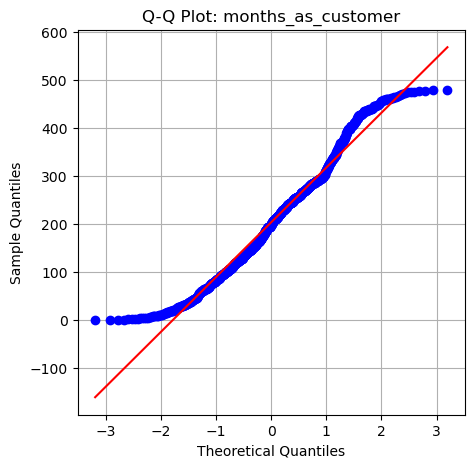

injury_claim — Shapiro-Wilk Test: W = 0.9592, p-value = 0.0000
❌ Likely NOT normal distribution (reject H0)


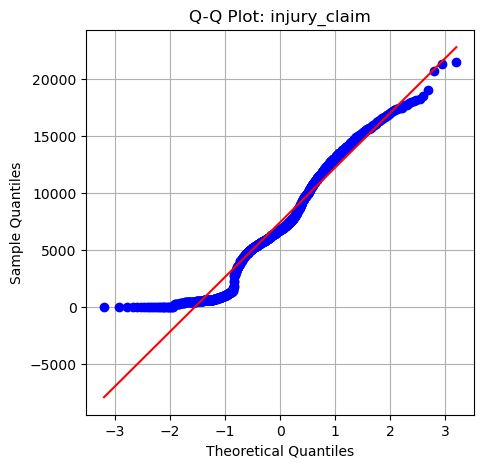

property_claim — Shapiro-Wilk Test: W = 0.9624, p-value = 0.0000
❌ Likely NOT normal distribution (reject H0)


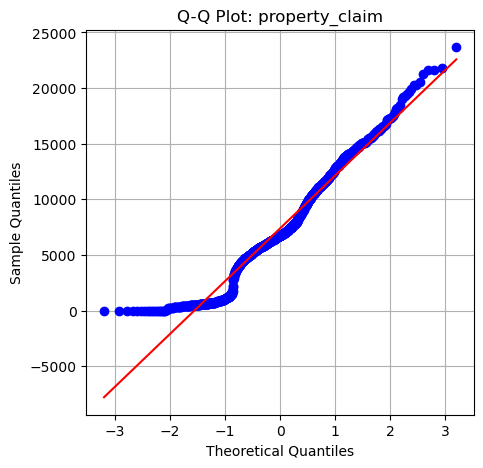

vehicle_claim — Shapiro-Wilk Test: W = 0.9141, p-value = 0.0000
❌ Likely NOT normal distribution (reject H0)


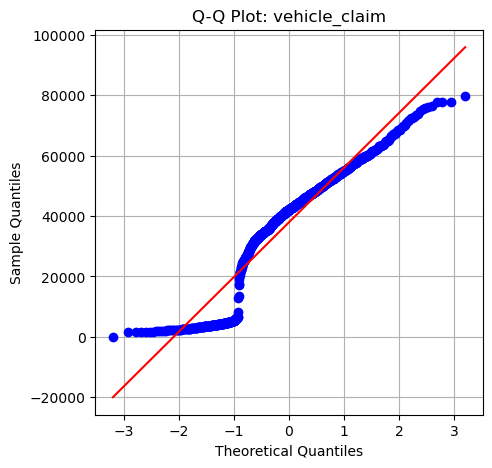

policy_annual_premium — Shapiro-Wilk Test: W = 0.9993, p-value = 0.9793
✅ Likely normal distribution (fail to reject H0)


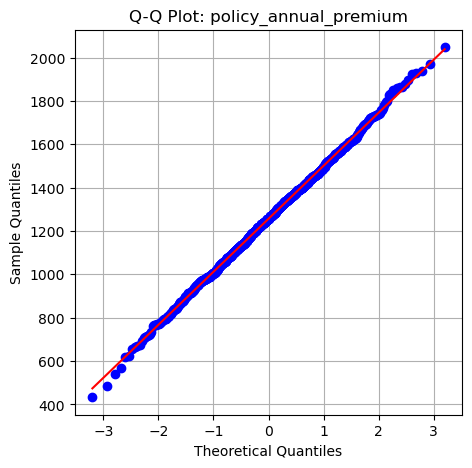

In [1961]:
summary = check_all_columns_normality(df_cleaned)
summary


check Anderson-Darling Test  #เหมาะกับdataที่มีขนาดใหญ่

📊 Anderson-Darling Test for 'months_as_customer': A² = 4.7455
Critical values (sig level %):
  - 15.0%: 0.5740 → ❌ Reject H0
  - 10.0%: 0.6530 → ❌ Reject H0
  - 5.0%: 0.7840 → ❌ Reject H0
  - 2.5%: 0.9140 → ❌ Reject H0
  - 1.0%: 1.0880 → ❌ Reject H0



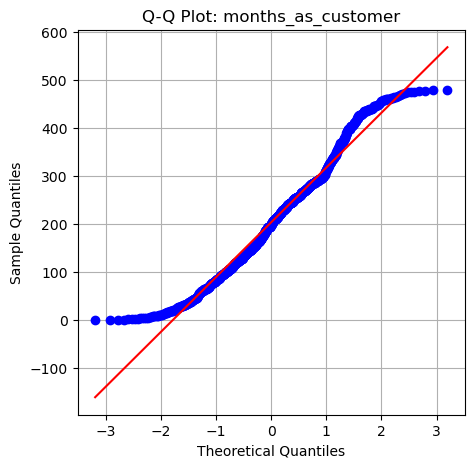

📊 Anderson-Darling Test for 'injury_claim': A² = 10.6602
Critical values (sig level %):
  - 15.0%: 0.5740 → ❌ Reject H0
  - 10.0%: 0.6530 → ❌ Reject H0
  - 5.0%: 0.7840 → ❌ Reject H0
  - 2.5%: 0.9140 → ❌ Reject H0
  - 1.0%: 1.0880 → ❌ Reject H0



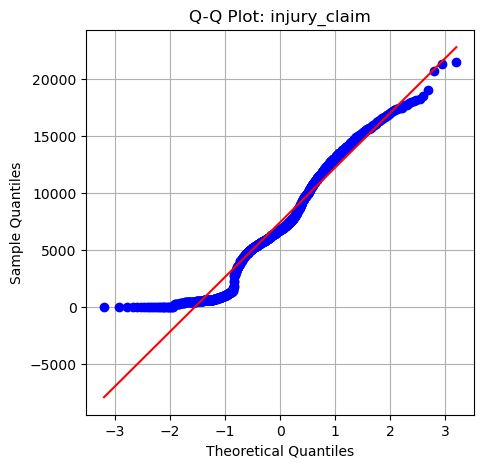

📊 Anderson-Darling Test for 'property_claim': A² = 9.5739
Critical values (sig level %):
  - 15.0%: 0.5740 → ❌ Reject H0
  - 10.0%: 0.6530 → ❌ Reject H0
  - 5.0%: 0.7840 → ❌ Reject H0
  - 2.5%: 0.9140 → ❌ Reject H0
  - 1.0%: 1.0880 → ❌ Reject H0



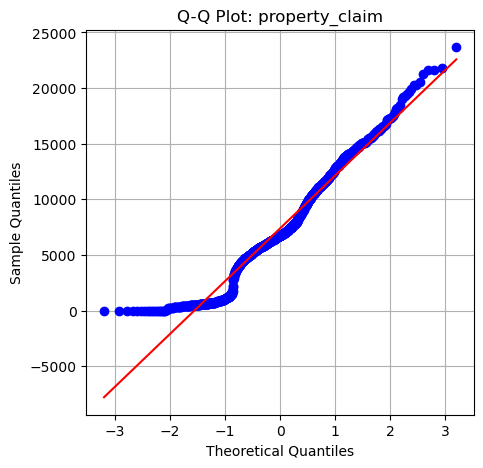

📊 Anderson-Darling Test for 'vehicle_claim': A² = 32.2880
Critical values (sig level %):
  - 15.0%: 0.5740 → ❌ Reject H0
  - 10.0%: 0.6530 → ❌ Reject H0
  - 5.0%: 0.7840 → ❌ Reject H0
  - 2.5%: 0.9140 → ❌ Reject H0
  - 1.0%: 1.0880 → ❌ Reject H0



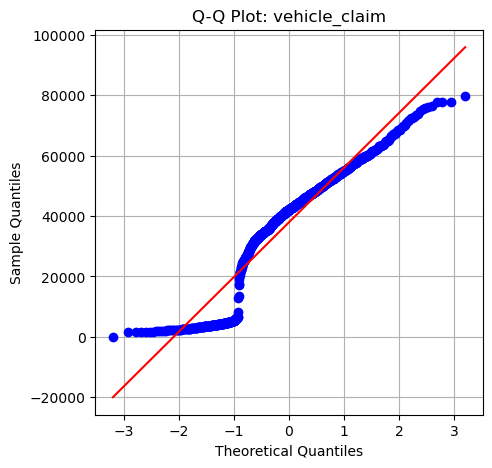

📊 Anderson-Darling Test for 'policy_annual_premium': A² = 0.1695
Critical values (sig level %):
  - 15.0%: 0.5740 → ✅ Fail to Reject H0
  - 10.0%: 0.6530 → ✅ Fail to Reject H0
  - 5.0%: 0.7840 → ✅ Fail to Reject H0
  - 2.5%: 0.9140 → ✅ Fail to Reject H0
  - 1.0%: 1.0880 → ✅ Fail to Reject H0



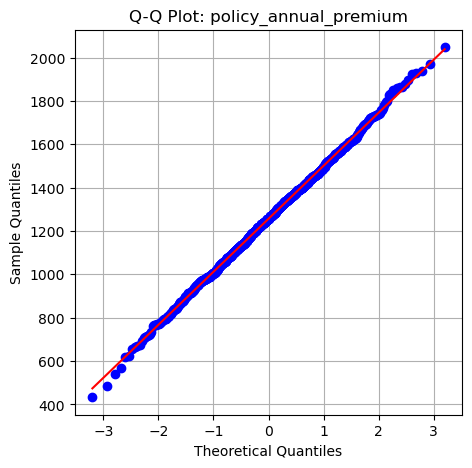

In [1962]:
summary = check_normality_anderson(df_cleaned)
summary


data tranform

In [1963]:
df_cleaned_normalize = df_cleaned.copy()


In [1964]:
# ตัวอย่าง: แปลง 'months_as_customer' ด้วย Yeo-Johnson

df_cleaned_normalize['months_as_customer'] = normalize_column(df_cleaned_normalize, 'months_as_customer', method='sqrt')
df_cleaned_normalize['vehicle_claim'] = normalize_column(
    df_cleaned_normalize, 'vehicle_claim', method='yeo-johnson')
df_cleaned_normalize['property_claim'] = normalize_column(
    df_cleaned_normalize, 'property_claim', method='yeo-johnson')


months_as_customer — Shapiro-Wilk Test: W = 0.9804, p-value = 0.0000
❌ Likely NOT normal distribution (reject H0)


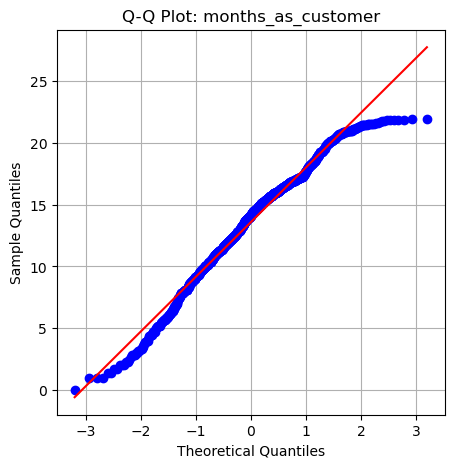

injury_claim — Shapiro-Wilk Test: W = 0.9592, p-value = 0.0000
❌ Likely NOT normal distribution (reject H0)


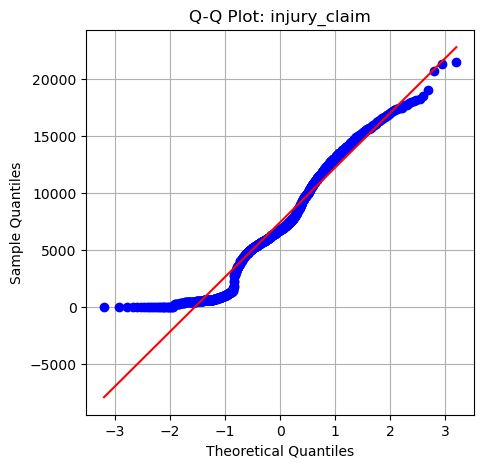

property_claim — Shapiro-Wilk Test: W = 0.9601, p-value = 0.0000
❌ Likely NOT normal distribution (reject H0)


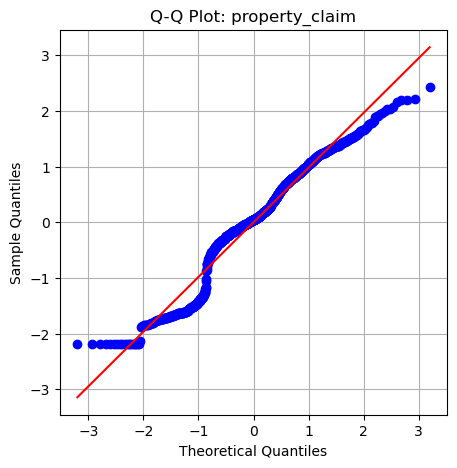

vehicle_claim — Shapiro-Wilk Test: W = 0.9254, p-value = 0.0000
❌ Likely NOT normal distribution (reject H0)


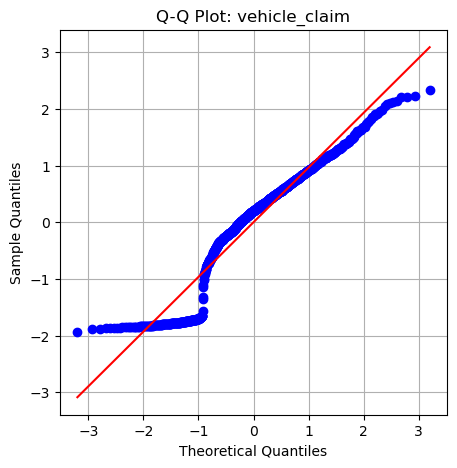

policy_annual_premium — Shapiro-Wilk Test: W = 0.9993, p-value = 0.9793
✅ Likely normal distribution (fail to reject H0)


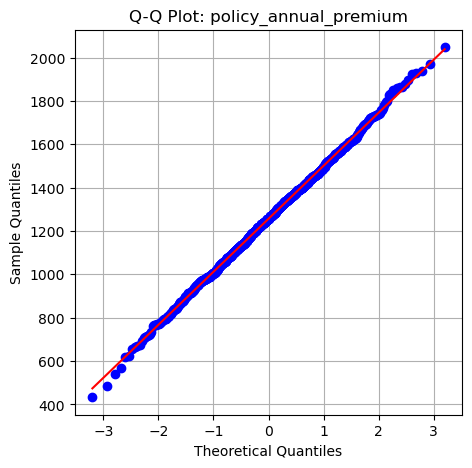

In [1965]:
summary = check_all_columns_normality(df_cleaned_normalize)
summary


## check Non-singularity 

In [1966]:
summary = check_determinant(df_cleaned)
summary


✅ Covariance matrix is **non-singular** (determinant = 34131782160115896809476467982336.000000)


3.4131782160115897e+31

# check assumption dbscan

## check density separation

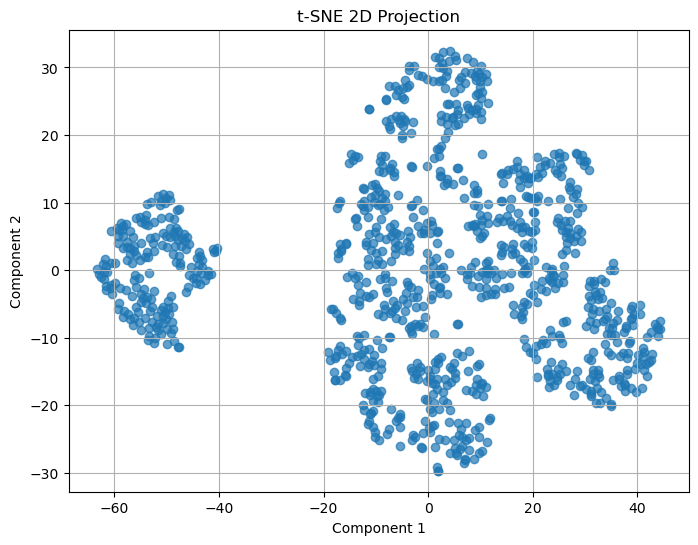

In [1967]:
# สมมุติ df มี column: ['age', 'income', 'spending_score', 'cluster']
plot_tsne_clusters(df_cleaned, columns =['months_as_customer', 'injury_claim', 'property_claim', 'vehicle_claim',
       'policy_annual_premium'])



# Model

## model robust mahalanobis anomaly

In [1968]:
df_result_mh = robust_mahalanobis_anomaly(df_cleaned, threshold_percentile=0.6)
df_result_mh


,months_as_customer,injury_claim,property_claim,vehicle_claim,policy_annual_premium,mahalanobis_distance,anomaly
0,328,6510,13020,52080,1406.91,781.621487,1
1,228,780,780,3510,1197.22,1.874284,0
2,134,7700,3850,23100,1413.14,274.102841,0
3,256,6340,6340,50720,1415.74,2.916480,0
4,228,1300,650,4550,1583.91,11.421065,0
...,...,...,...,...,...,...,...
995,3,17440,8720,61040,1310.80,1410.113298,1
996,285,18080,18080,72320,1436.79,7.097462,0
997,130,7500,7500,52500,1383.49,2.375512,0
998,458,5220,5220,36540,1356.92,6.034871,0


## p-value

In [1969]:
result_df = add_pvalue_to_result(df_result_mh, alpha=0.1)
result_df


,months_as_customer,injury_claim,property_claim,vehicle_claim,policy_annual_premium,mahalanobis_distance,anomaly,p_value,anomaly_pvalue
0,328,6510,13020,52080,1406.91,781.621487,1,0.000000e+00,1
1,228,780,780,3510,1197.22,1.874284,0,6.214306e-01,0
2,134,7700,3850,23100,1413.14,274.102841,0,0.000000e+00,1
3,256,6340,6340,50720,1415.74,2.916480,0,1.304728e-01,0
4,228,1300,650,4550,1583.91,11.421065,0,0.000000e+00,1
...,...,...,...,...,...,...,...,...,...
995,3,17440,8720,61040,1310.80,1410.113298,1,0.000000e+00,1
996,285,18080,18080,72320,1436.79,7.097462,0,1.161870e-09,1
997,130,7500,7500,52500,1383.49,2.375512,0,3.425142e-01,0
998,458,5220,5220,36540,1356.92,6.034871,0,7.828040e-07,1


## eda model mahalanobis anomaly

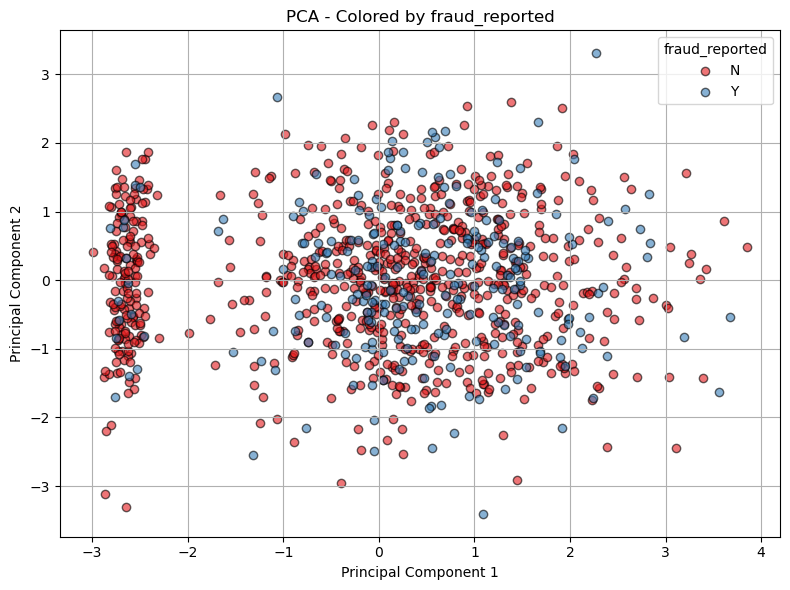

In [1970]:
plot_pca_anomaly(df,anomaly_col='fraud_reported')

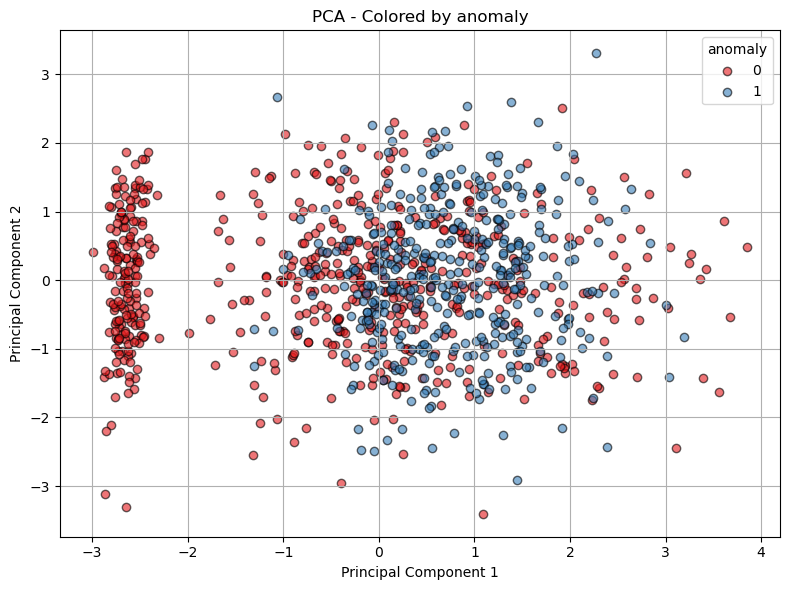

In [1971]:
plot_pca_anomaly(result_df,anomaly_col='anomaly')

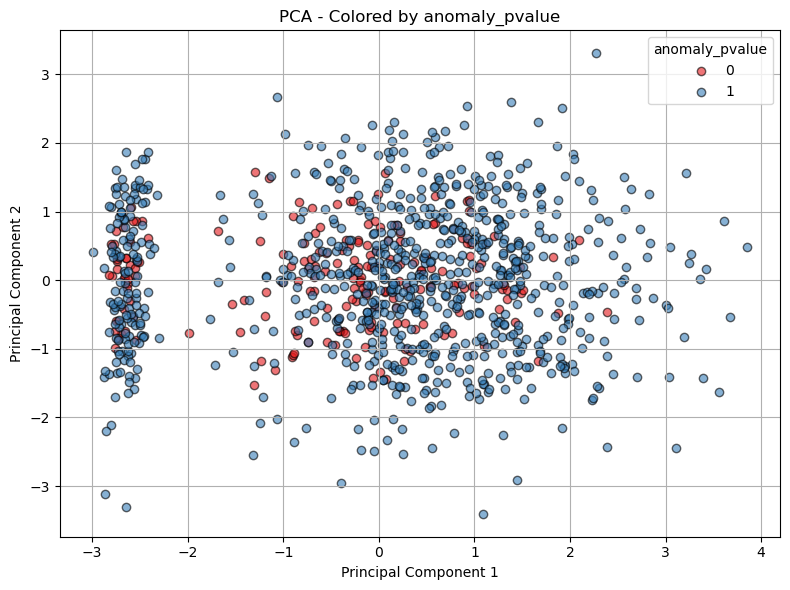

In [1972]:
plot_pca_anomaly(result_df,anomaly_col='anomaly_pvalue')

## Model dbscan

In [1973]:
df_result_dbscan = dbscan_anomaly(df_cleaned, eps=0.8, min_samples=5)

df_result_dbscan  


,months_as_customer,injury_claim,property_claim,vehicle_claim,policy_annual_premium,cluster,anomaly
0,328,6510,13020,52080,1406.91,0,0
1,228,780,780,3510,1197.22,0,0
2,134,7700,3850,23100,1413.14,0,0
3,256,6340,6340,50720,1415.74,0,0
4,228,1300,650,4550,1583.91,0,0
...,...,...,...,...,...,...,...
995,3,17440,8720,61040,1310.80,0,0
996,285,18080,18080,72320,1436.79,0,0
997,130,7500,7500,52500,1383.49,0,0
998,458,5220,5220,36540,1356.92,0,0


## Model IF

In [1974]:
df_result_if = isolation_forest(df_cleaned, contamination=0.1, n_estimators=200, max_samples=0.6)
df_result_if



,months_as_customer,injury_claim,property_claim,vehicle_claim,policy_annual_premium,anomaly,anomaly_score
0,328,6510,13020,52080,1406.91,0,-0.075740
1,228,780,780,3510,1197.22,0,-0.093528
2,134,7700,3850,23100,1413.14,0,-0.073407
3,256,6340,6340,50720,1415.74,0,-0.127249
4,228,1300,650,4550,1583.91,0,-0.062759
...,...,...,...,...,...,...,...
995,3,17440,8720,61040,1310.80,1,0.040751
996,285,18080,18080,72320,1436.79,1,0.074884
997,130,7500,7500,52500,1383.49,0,-0.122638
998,458,5220,5220,36540,1356.92,0,-0.047034


# Quantify Model

## quantify model mahalanobis

In [1975]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, fbeta_score
import pandas as pd


In [1976]:
df = convert_fraud_column(df)
df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17 00:00:00,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,1
1,228,42,342868,2006-06-27 00:00:00,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,1
2,134,29,687698,2000-09-06 00:00:00,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,0
3,256,41,227811,1990-05-25 00:00:00,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1
4,228,44,367455,2014-06-06 00:00:00,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16 00:00:00,OH,500/1000,1000,1310.8,0,431289,...,1,?,87200,17440,8720,61040,Honda,Accord,2006,0
996,285,41,186934,2014-01-05 00:00:00,IL,100/300,1000,1436.79,0,608177,...,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015,0
997,130,34,918516,2003-02-17 00:00:00,OH,250/500,500,1383.49,3000000,442797,...,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,0
998,458,62,533940,2011-11-18 00:00:00,IL,500/1000,2000,1356.92,5000000,441714,...,1,YES,46980,5220,5220,36540,Audi,A5,1998,0


In [1977]:
df_merged = merge_model_results(df, df_result_mh)
df_merged 

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,mahalanobis_distance,anomaly,p_value,anomaly_pvalue
0,328,48,521585,2014-10-17 00:00:00,OH,250/500,1000,1406.91,0,466132,...,13020,52080,Saab,92x,2004,1,781.621487,1,0.000000e+00,1
1,228,42,342868,2006-06-27 00:00:00,IN,250/500,2000,1197.22,5000000,468176,...,780,3510,Mercedes,E400,2007,1,1.874284,0,6.214306e-01,0
2,134,29,687698,2000-09-06 00:00:00,OH,100/300,2000,1413.14,5000000,430632,...,3850,23100,Dodge,RAM,2007,0,274.102841,0,0.000000e+00,1
3,256,41,227811,1990-05-25 00:00:00,IL,250/500,2000,1415.74,6000000,608117,...,6340,50720,Chevrolet,Tahoe,2014,1,2.916480,0,1.304728e-01,0
4,228,44,367455,2014-06-06 00:00:00,IL,500/1000,1000,1583.91,6000000,610706,...,650,4550,Accura,RSX,2009,0,11.421065,0,0.000000e+00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16 00:00:00,OH,500/1000,1000,1310.8,0,431289,...,8720,61040,Honda,Accord,2006,0,1410.113298,1,0.000000e+00,1
996,285,41,186934,2014-01-05 00:00:00,IL,100/300,1000,1436.79,0,608177,...,18080,72320,Volkswagen,Passat,2015,0,7.097462,0,1.161870e-09,1
997,130,34,918516,2003-02-17 00:00:00,OH,250/500,500,1383.49,3000000,442797,...,7500,52500,Suburu,Impreza,1996,0,2.375512,0,3.425142e-01,0
998,458,62,533940,2011-11-18 00:00:00,IL,500/1000,2000,1356.92,5000000,441714,...,5220,36540,Audi,A5,1998,0,6.034871,0,7.828040e-07,1


In [1978]:
quantify_mh = evaluate_binary_classification(df_merged , y_pred=df_merged['anomaly'])
quantify_mh

{'precision': 0.3375,
 'recall': 0.5465587044534413,
 'f1_score': 0.41731066460587324,
 'confusion_matrix': [[488, 265], [112, 135]],
 'f0.5_score': 0.3654574986464537}

In [1979]:
quantify_mh_p = evaluate_binary_classification(df_merged , y_pred=df_merged['anomaly_pvalue'])
quantify_mh_p

{'precision': 0.26092384519350814,
 'recall': 0.8461538461538461,
 'f1_score': 0.3988549618320611,
 'confusion_matrix': [[161, 592], [38, 209]],
 'f0.5_score': 0.3028107794842075}

## quantify model dbscan

In [1980]:
df_merged_dbscan = merge_model_results(df, df_result_dbscan)
df_merged_dbscan

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,anomaly
0,328,48,521585,2014-10-17 00:00:00,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,1,0
1,228,42,342868,2006-06-27 00:00:00,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,1,0
2,134,29,687698,2000-09-06 00:00:00,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,0,0
3,256,41,227811,1990-05-25 00:00:00,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1,0
4,228,44,367455,2014-06-06 00:00:00,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16 00:00:00,OH,500/1000,1000,1310.8,0,431289,...,?,87200,17440,8720,61040,Honda,Accord,2006,0,0
996,285,41,186934,2014-01-05 00:00:00,IL,100/300,1000,1436.79,0,608177,...,?,108480,18080,18080,72320,Volkswagen,Passat,2015,0,0
997,130,34,918516,2003-02-17 00:00:00,OH,250/500,500,1383.49,3000000,442797,...,YES,67500,7500,7500,52500,Suburu,Impreza,1996,0,0
998,458,62,533940,2011-11-18 00:00:00,IL,500/1000,2000,1356.92,5000000,441714,...,YES,46980,5220,5220,36540,Audi,A5,1998,0,0


In [1981]:
quantify_dbscan = evaluate_binary_classification(df_merged_dbscan , y_pred=df_merged_dbscan['anomaly'])
quantify_dbscan

{'precision': 0.38509316770186336,
 'recall': 0.25101214574898784,
 'f1_score': 0.30392156862745096,
 'confusion_matrix': [[654, 99], [185, 62]],
 'f0.5_score': 0.3479236812570146}

## quantify model if

In [1982]:
df_merged_if = merge_model_results(df, df_result_if)
df_merged_if

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,anomaly
0,328,48,521585,2014-10-17 00:00:00,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,1,0
1,228,42,342868,2006-06-27 00:00:00,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,1,0
2,134,29,687698,2000-09-06 00:00:00,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,0,0
3,256,41,227811,1990-05-25 00:00:00,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1,0
4,228,44,367455,2014-06-06 00:00:00,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16 00:00:00,OH,500/1000,1000,1310.8,0,431289,...,?,87200,17440,8720,61040,Honda,Accord,2006,0,1
996,285,41,186934,2014-01-05 00:00:00,IL,100/300,1000,1436.79,0,608177,...,?,108480,18080,18080,72320,Volkswagen,Passat,2015,0,1
997,130,34,918516,2003-02-17 00:00:00,OH,250/500,500,1383.49,3000000,442797,...,YES,67500,7500,7500,52500,Suburu,Impreza,1996,0,0
998,458,62,533940,2011-11-18 00:00:00,IL,500/1000,2000,1356.92,5000000,441714,...,YES,46980,5220,5220,36540,Audi,A5,1998,0,0


In [1983]:
quantify_if = evaluate_binary_classification(df_merged_if , y_pred=df_merged_if['anomaly'])
quantify_if

{'precision': 0.35,
 'recall': 0.1417004048582996,
 'f1_score': 0.2017291066282421,
 'confusion_matrix': [[688, 65], [212, 35]],
 'f0.5_score': 0.2704791344667697}

## best quantile & alpha

In [1984]:
percentile_df, alpha_df, best_q, best_a = evaluate_percentile_alpha_performance_with_best(
    X_input=df_cleaned,
    df_true=df,
    label_col='fraud_reported',
    percentile=np.arange(1, 0.49, -0.05),
    alphas=np.arange(0, 0.401, 0.05),
    beta=0.5
)

In [1985]:
percentile_df

,percentile,precision,recall,f0.5,f1,tp,tn,fp,fn,anomaly_count
0,Mahalanobis | percentile : 1.0,0.000000,0.000000,0.000000,0.000000,0,753,0,247,0
1,Mahalanobis | percentile : 0.95,0.400000,0.080972,0.223714,0.134680,20,723,30,227,50
2,Mahalanobis | percentile : 0.9,0.390000,0.157895,0.301391,0.224784,39,692,61,208,100
3,Mahalanobis | percentile : 0.85,0.366667,0.222672,0.324675,0.277078,55,658,95,192,150
4,Mahalanobis | percentile : 0.8,0.380000,0.307692,0.362942,0.340045,76,629,124,171,200
5,Mahalanobis | percentile : 0.75,0.348000,0.352227,0.348837,0.350101,87,590,163,160,250
6,Mahalanobis | percentile : 0.7,0.343333,0.417004,0.355909,0.376600,103,556,197,144,300
7,Mahalanobis | percentile : 0.65,0.337143,0.477733,0.358227,0.395310,118,521,232,129,350
8,Mahalanobis | percentile : 0.6,0.337500,0.546559,0.365457,0.417311,135,488,265,112,400
9,Mahalanobis | percentile : 0.55,0.326667,0.595142,0.359062,0.421808,147,450,303,100,450


In [1986]:
alpha_df

,alpha,precision,recall,f0.5,f1,tp,tn,fp,fn,anomaly_count
0,Mahalanobis | alpha :0.0,0.000000,0.000000,0.000000,0.000000,0,753,0,247,0
1,Mahalanobis | alpha :0.05,0.260925,0.821862,0.302173,0.396098,203,178,575,44,778
2,Mahalanobis | alpha :0.1,0.260924,0.846154,0.302811,0.398855,209,161,592,38,801
3,Mahalanobis | alpha :0.15,0.257317,0.854251,0.299121,0.395501,211,144,609,36,820
4,Mahalanobis | alpha :0.2,0.254480,0.862348,0.296245,0.392989,213,129,624,34,837
5,Mahalanobis | alpha :0.25,0.253239,0.870445,0.295086,0.392336,215,119,634,32,849
6,Mahalanobis | alpha :0.3,0.252023,0.882591,0.294038,0.392086,218,106,647,29,865
7,Mahalanobis | alpha :0.35,0.251147,0.886640,0.293173,0.391421,219,100,653,28,872
8,Mahalanobis | alpha :0.4,0.251136,0.894737,0.293337,0.392192,221,94,659,26,880


## best dbscan

In [1987]:
results_df, best_result = evaluate_dbscan_performance_with_best(
    df_input= df_cleaned,
    df_true=df
)


In [1988]:
results_df

,model,precision,recall,f0.5,f1,tp,tn,fp,fn,anomaly_count
0,"dbscann | eps : 0.1 , min_sample : 3",0.247000,1.000000,0.290794,0.396151,247,0,753,0,1000
1,"dbscann | eps : 0.1 , min_sample : 4",0.247000,1.000000,0.290794,0.396151,247,0,753,0,1000
2,"dbscann | eps : 0.1 , min_sample : 5",0.247000,1.000000,0.290794,0.396151,247,0,753,0,1000
3,"dbscann | eps : 0.1 , min_sample : 6",0.247000,1.000000,0.290794,0.396151,247,0,753,0,1000
4,"dbscann | eps : 0.1 , min_sample : 7",0.247000,1.000000,0.290794,0.396151,247,0,753,0,1000
...,...,...,...,...,...,...,...,...,...,...
75,"dbscann | eps : 1.0 , min_sample : 6",0.410256,0.129555,0.286225,0.196923,32,707,46,215,78
76,"dbscann | eps : 1.0 , min_sample : 7",0.406977,0.141700,0.296108,0.210210,35,702,51,212,86
77,"dbscann | eps : 1.0 , min_sample : 8",0.417582,0.153846,0.310966,0.224852,38,700,53,209,91
78,"dbscann | eps : 1.0 , min_sample : 9",0.412371,0.161943,0.314961,0.232558,40,696,57,207,97


In [1989]:
best_result

model            dbscann | eps : 0.8 , min_sample : 5
precision                                    0.385093
recall                                       0.251012
f0.5                                         0.347924
f1                                           0.303922
tp                                                 62
tn                                                654
fp                                                 99
fn                                                185
anomaly_count                                     161
Name: 58, dtype: object

## best if

In [1990]:
results_df, best = evaluate_if_performance_with_best(df_cleaned, df, label_col='fraud_reported')



In [1991]:
results_df

,model,precision,recall,f0.5,f1,tp,tn,fp,fn,anomaly_count
0,"Isolation Forest | contamination: 0.01, n_esti...",0.300000,0.012146,0.052265,0.023346,3,746,7,244,10
1,"Isolation Forest | contamination: 0.01, n_esti...",0.400000,0.016194,0.069686,0.031128,4,747,6,243,10
2,"Isolation Forest | contamination: 0.01, n_esti...",0.300000,0.012146,0.052265,0.023346,3,746,7,244,10
3,"Isolation Forest | contamination: 0.01, n_esti...",0.400000,0.016194,0.069686,0.031128,4,747,6,243,10
4,"Isolation Forest | contamination: 0.01, n_esti...",0.400000,0.016194,0.069686,0.031128,4,747,6,243,10
5,"Isolation Forest | contamination: 0.01, n_esti...",0.300000,0.012146,0.052265,0.023346,3,746,7,244,10
6,"Isolation Forest | contamination: 0.01, n_esti...",0.300000,0.012146,0.052265,0.023346,3,746,7,244,10
7,"Isolation Forest | contamination: 0.01, n_esti...",0.400000,0.016194,0.069686,0.031128,4,747,6,243,10
8,"Isolation Forest | contamination: 0.01, n_esti...",0.400000,0.016194,0.069686,0.031128,4,747,6,243,10
9,"Isolation Forest | contamination: 0.01, n_esti...",0.400000,0.016194,0.069686,0.031128,4,747,6,243,10


In [1992]:
best

model            Isolation Forest | contamination: 0.1, n_estim...
precision                                                     0.35
recall                                                      0.1417
f0.5                                                      0.270479
f1                                                        0.201729
tp                                                              35
tn                                                             688
fp                                                              65
fn                                                             212
anomaly_count                                                  100
Name: 45, dtype: object

# ensemble

## voting

In [1993]:
df_result_mh

,months_as_customer,injury_claim,property_claim,vehicle_claim,policy_annual_premium,mahalanobis_distance,anomaly,p_value,anomaly_pvalue
0,328,6510,13020,52080,1406.91,781.621487,1,0.000000e+00,1
1,228,780,780,3510,1197.22,1.874284,0,6.214306e-01,0
2,134,7700,3850,23100,1413.14,274.102841,0,0.000000e+00,1
3,256,6340,6340,50720,1415.74,2.916480,0,1.304728e-01,0
4,228,1300,650,4550,1583.91,11.421065,0,0.000000e+00,1
...,...,...,...,...,...,...,...,...,...
995,3,17440,8720,61040,1310.80,1410.113298,1,0.000000e+00,1
996,285,18080,18080,72320,1436.79,7.097462,0,1.161870e-09,1
997,130,7500,7500,52500,1383.49,2.375512,0,3.425142e-01,0
998,458,5220,5220,36540,1356.92,6.034871,0,7.828040e-07,1


In [1994]:
# สมมุติว่า df มีคอลัมน์ anomaly_if, anomaly_db, anomaly_md
df_voting = weighted_voting_from_scores(df,df_result_if, df_result_dbscan, df_result_mh, 
                                       f05_if=quantify_if['f0.5_score'].astype(float), f05_db=quantify_dbscan['f0.5_score'].astype(float),
                                       f05_md=quantify_mh['f0.5_score'].astype(float))

df_voting


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,anomaly_if,anomaly_db,anomaly_md,score_voted,anomaly_voted
0,328,48,521585,2014-10-17 00:00:00,OH,250/500,1000,1406.91,0,466132,...,52080,Saab,92x,2004,1,0,0,1,0.371453,0
1,228,42,342868,2006-06-27 00:00:00,IN,250/500,2000,1197.22,5000000,468176,...,3510,Mercedes,E400,2007,1,0,0,0,0.000000,0
2,134,29,687698,2000-09-06 00:00:00,OH,100/300,2000,1413.14,5000000,430632,...,23100,Dodge,RAM,2007,0,0,0,0,0.000000,0
3,256,41,227811,1990-05-25 00:00:00,IL,250/500,2000,1415.74,6000000,608117,...,50720,Chevrolet,Tahoe,2014,1,0,0,0,0.000000,0
4,228,44,367455,2014-06-06 00:00:00,IL,500/1000,1000,1583.91,6000000,610706,...,4550,Accura,RSX,2009,0,0,0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16 00:00:00,OH,500/1000,1000,1310.8,0,431289,...,61040,Honda,Accord,2006,0,1,0,1,0.646369,1
996,285,41,186934,2014-01-05 00:00:00,IL,100/300,1000,1436.79,0,608177,...,72320,Volkswagen,Passat,2015,0,1,0,0,0.274916,0
997,130,34,918516,2003-02-17 00:00:00,OH,250/500,500,1383.49,3000000,442797,...,52500,Suburu,Impreza,1996,0,0,0,0,0.000000,0
998,458,62,533940,2011-11-18 00:00:00,IL,500/1000,2000,1356.92,5000000,441714,...,36540,Audi,A5,1998,0,0,0,0,0.000000,0


In [1995]:
quantify_voting = evaluate_binary_classification(df_voting , y_pred=df_voting['anomaly_voted'])
quantify_voting

{'precision': 0.37777777777777777,
 'recall': 0.20647773279352227,
 'f1_score': 0.2670157068062827,
 'confusion_matrix': [[669, 84], [196, 51]],
 'f0.5_score': 0.3240152477763659}

## Stacking

In [1996]:
meta_model, X_test, y_test, y_pred ,f05 = stacking_xgb(df_result_if, df_result_dbscan, df_result_mh, df)


📊 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80       226
           1       0.29      0.20      0.24        74

    accuracy                           0.68       300
   macro avg       0.53      0.52      0.52       300
weighted avg       0.65      0.68      0.66       300

🎯 F0.5 score: 0.2660


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[13:48:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




# 1,0

## convert to 0,1

In [1997]:
def binarize_high_percentile(df, percentile_threshold=0.975):
    """
    แปลงค่าทุก column ให้เป็น 1 ถ้าเกิน percentile ที่กำหนด, อื่น ๆ เป็น 0

    Parameters:
        df (pd.DataFrame): DataFrame ที่มีแต่ค่าตัวเลข
        percentile_threshold (float): ค่าที่ใช้ตัด (default = 0.975)

    Returns:
        pd.DataFrame: DataFrame ที่แปลงเป็น binary แล้ว (1 ถ้าเกิน percentile, 0 ถ้าไม่เกิน)
    """
    binary_df = df.copy()
    for col in binary_df.columns:
        threshold = np.percentile(binary_df[col], percentile_threshold * 100)
        binary_df[col] = (binary_df[col] > threshold).astype(int)
    return binary_df


In [1998]:
binary_df = binarize_high_percentile(df_cleaned, percentile_threshold=0.95)
binary_df

,months_as_customer,injury_claim,property_claim,vehicle_claim,policy_annual_premium
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
995,0,1,0,0,0
996,0,1,1,1,0
997,0,0,0,0,0
998,1,0,0,0,0


## model no sacler

In [1999]:


def robust_mahalanobis_anomaly_noscaler(X_input, threshold_percentile=0.8, return_distance=False, random_state=42):
    """
    Robust Mahalanobis Distance anomaly detection (ไม่ทำ Standardization)

    Parameters:
    - X_input: pandas DataFrame (raw scale, ไม่ทำ scaling)
    - threshold_percentile: float, percentile cutoff (default=0.8)
    - return_distance: if True, return also the threshold
    - random_state: int, for reproducibility

    Returns:
    - result_df: DataFrame (original scale) + mahalanobis_distance + anomaly
    """
    if not isinstance(X_input, pd.DataFrame):
        raise ValueError("X_input must be a pandas DataFrame")

    # ✅ ไม่ทำ StandardScaler
    mcd = MinCovDet(random_state=random_state).fit(X_input)
    distances = mcd.mahalanobis(X_input)

    threshold = np.percentile(distances, threshold_percentile *100)
    anomalies = (distances > threshold).astype(int)

    result_df = X_input.copy()
    result_df["mahalanobis_distance"] = distances
    result_df["anomaly"] = anomalies

    if return_distance:
        return result_df, threshold
    else:
        return result_df



In [2000]:
# result_df = robust_mahalanobis_anomaly_noscaler(binary_df, threshold_percentile=0.9)
# result_df

In [2001]:
# result_df = add_pvalue_to_result(result_df, alpha=0.01)
# result_df

In [2002]:
# result_df['anomaly'].value_counts()

In [2003]:
# result_df['anomaly_pvalue'].value_counts()

In [2004]:
# # Final function to run
# def evaluate_percentile_alpha_performance_with_best10(
#     X_input,
#     df_true,
#     label_col='fraud_reported',
#     percentiles=np.arange(0.90, 0.991, 0.01),
#     alphas=np.arange(0.01, 0.201, 0.025),
#     beta=0.5 
# ):
#     if df_true[label_col].dtype == object:
#         y_true = df_true[label_col].map({'Y': 1, 'N': 0}).astype(int)
#     else:
#         y_true = df_true[label_col].astype(int)

#     percentile_rows = []
#     for q in percentiles:
#         result_df = robust_mahalanobis_anomaly_noscaler(X_input, threshold_percentile=q)
#         y_pred = result_df['anomaly']
#         percentile_rows.append({
#             'percentile': round(q, 3),
#             'precision': precision_score(y_true, y_pred, zero_division=0),
#             'recall': recall_score(y_true, y_pred, zero_division=0),
#             f'f{beta}': fbeta_score(y_true, y_pred, beta=beta, zero_division=0),
#             'f1': f1_score(y_true, y_pred, zero_division=0)
#         })
        
#     percentile_df = pd.DataFrame(percentile_rows)
#     best_q_row = percentile_df.loc[percentile_df[f'f{beta}'].idxmax()]

#     result_df = robust_mahalanobis_anomaly_noscaler(X_input, threshold_percentile=0.975)
#     result_df = add_pvalue_to_result(result_df, alpha=0.05)

#     alpha_rows = []
#     for alpha in alphas:
#         y_pred = (result_df["p_value"] < alpha).astype(int)
#         alpha_rows.append({
#             'alpha': round(alpha, 3),
#             'precision': precision_score(y_true, y_pred, zero_division=0),
#             'recall': recall_score(y_true, y_pred, zero_division=0),
#             f'f{beta}': fbeta_score(y_true, y_pred, beta=beta, zero_division=0),
#             'f1': f1_score(y_true, y_pred, zero_division=0)
#         })

#     alpha_df = pd.DataFrame(alpha_rows)
#     best_a_row = alpha_df.loc[alpha_df[f'f{beta}'].idxmax()]

#     return percentile_df, alpha_df, best_q_row, best_a_row


In [2005]:
# percentiledf, alpha_df, best_q, best_a = evaluate_percentile_alpha_performance_with_best10(
#     X_input=binary_df,
#     df_true=df,
#     label_col='fraud_reported',
#     percentile=np.arange(1, 0.69, -0.025),
#     alphas=np.arange(0.00, 0.201, 0.025),
#     beta=0.5
# )

In [2006]:
# percentile_df


In [2007]:
# alpha_df

In [2008]:
# import matplotlib.pyplot as plt
# plt.hist(result_df["mahalanobis_distance"], bins=50)
# plt.title("Histogram of Mahalanobis Distance")
# plt.show()
